<a href="https://colab.research.google.com/github/adarshmodh/Deep-Learning-Assignments/blob/master/ESE546_HW1_Q6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Tensorboard setup

Go to the link generated by the code to look at the training loss curve, you can add accuracy and other things to the plot. Refer to the recitation 2 code for referance.

In [0]:
LOG_DIR = './logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

!if [ -f ngrok ] ; then echo "Ngrok already installed" ; else wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip > /dev/null 2>&1 && unzip ngrok-stable-linux-amd64.zip > /dev/null 2>&1 ; fi


Ngrok already installed


In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print('Tensorboard Link: ' +str(json.load(sys.stdin)['tunnels'][0]['public_url']))"

Tensorboard Link: https://7bb6bd03.ngrok.io


In [0]:
# Code referenced from https://gist.github.com/gyglim/1f8dfb1b5c82627ae3efcfbbadb9f514
import tensorflow as tf
import numpy as np
import scipy.misc 
try:
    from StringIO import StringIO  # Python 2.7
except ImportError:
    from io import BytesIO         # Python 3.x


class Logger(object):
    
    def __init__(self, log_dir):
        """Create a summary writer logging to log_dir."""
        self.writer = tf.summary.FileWriter(log_dir)

    def scalar_summary(self, tag, value, step):
        """Log a scalar variable."""
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
        self.writer.add_summary(summary, step)

    def image_summary(self, tag, images, step):
        """Log a list of images."""

        img_summaries = []
        for i, img in enumerate(images):
            # Write the image to a string
            try:
                s = StringIO()
            except:
                s = BytesIO()
            scipy.misc.toimage(img).save(s, format="png")

            # Create an Image object
            img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                       height=img.shape[0],
                                       width=img.shape[1])
            # Create a Summary value
            img_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, i), image=img_sum))

        # Create and write Summary
        summary = tf.Summary(value=img_summaries)
        self.writer.add_summary(summary, step)
        
    def histo_summary(self, tag, values, step, bins=1000):
        """Log a histogram of the tensor of values."""

        # Create a histogram using numpy
        counts, bin_edges = np.histogram(values, bins=bins)

        # Fill the fields of the histogram proto
        hist = tf.HistogramProto()
        hist.min = float(np.min(values))
        hist.max = float(np.max(values))
        hist.num = int(np.prod(values.shape))
        hist.sum = float(np.sum(values))
        hist.sum_squares = float(np.sum(values**2))

        # Drop the start of the first bin
        bin_edges = bin_edges[1:]

        # Add bin edges and counts
        for edge in bin_edges:
            hist.bucket_limit.append(edge)
        for c in counts:
            hist.bucket.append(c)

        # Create and write Summary
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
        self.writer.add_summary(summary, step)
        self.writer.flush()

  

In [1]:
#just mount google drive
from google.colab import drive
# drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Training on CIFAR 10.


 The model currently does not achieve less than 12% validation error, you have to tweak the parameters to get it.

In [3]:
# torch and torchvision imports
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import random
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt
import numpy as np

# Uncomment for Tensorboard
# logger = Logger('./logs')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

# device = 'cpu'

# Reading in the dataset

from pathlib import Path

data_folder = Path("/content/gdrive/My Drive/ESE546_2019/HW1")

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(data_folder / "CIFAR_data/", train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(data_folder / "CIFAR_data/", train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [0]:

# Defining the model
class View(nn.Module):
    def __init__(self,o):
        super().__init__()
        self.o = o

    def forward(self,x):
        return x.view(-1, self.o)
    
class allcnn_t(nn.Module):
    def __init__(self, c1=96, c2= 192):
        super().__init__()
        d = 0.5

        def convbn(ci,co,ksz,s=1,pz=0):
            return nn.Sequential(
                nn.Conv2d(ci,co,ksz,stride=s,padding=pz),
                nn.ReLU(True),
                nn.BatchNorm2d(co))

        self.m = nn.Sequential(
            nn.Dropout(0.2),
            convbn(3,c1,3,1,1),
            convbn(c1,c1,3,1,1),
            convbn(c1,c1,3,2,1),
            nn.Dropout(d),
            convbn(c1,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,2,1),
            nn.Dropout(d),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,10,1,1),
            nn.AvgPool2d(8),
            View(10))

        print('Num parameters: ', sum([p.numel() for p in self.m.parameters()]))

    def forward(self, x):
        return self.m(x)


In [0]:

# The training loop

def train(net, optimizer, criterion, train_loader, test_loader, epochs, model_name, plot):
    model = net.to(device)
    total_step = len(train_loader)
    overall_step = 0

    training_epoch_loss  = []
    training_epoch_accuracy = []
    testing_epoch_loss  = []
    testing_epoch_accuracy = []
  

    for epoch in range(epochs):
        if epoch > 19:
            optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
        
        correct = 0
        total = 0
        running_loss = 0.0

        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to configured device
            images = images.to(device)
            labels = labels.to(device)
            #Forward Pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if (i+1) % 500 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))

        training_epoch_loss.append(running_loss/len(train_loader))
        training_epoch_accuracy.append(correct/total)

        # model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            test_running_loss = 0.0
            for i, (images, labels) in enumerate(test_loader):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))
        testing_epoch_loss.append(test_running_loss/len(test_loader))
        testing_epoch_accuracy.append(correct/total)

        if plot:
          info = { ('training_loss' + model_name): training_epoch_loss[-1] , ('training_accuracy' + model_name): training_epoch_accuracy[-1], ('testing_loss' + model_name): testing_epoch_loss[-1], ('testing_accuracy' + model_name): testing_epoch_accuracy[-1]}
          for tag, value in info.items():
            logger.scalar_summary(tag, value, overall_step+1)

    return training_epoch_loss, training_epoch_accuracy, testing_epoch_loss, testing_epoch_accuracy        


model = allcnn_t().to(device)
#TODO: Set it as number of epochs states in the question
epochs = 40
# TODO: Define the loss function as asked in the question
criterion = nn.CrossEntropyLoss()
# TODO: Set parameters as stated in the question
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True)
# Training loop called here
training_epoch_loss, training_epoch_accuracy, testing_epoch_loss, testing_epoch_accuracy = train(model, optimizer, criterion, trainloader, testloader, epochs, 'sgd4', True)


torch.save(model.state_dict(), data_folder / 'cifar10.pt')


Num parameters:  1667166
Epoch [1/40], Step [500/12500], Loss: 2.4011
Epoch [1/40], Step [1000/12500], Loss: 2.5756
Epoch [1/40], Step [1500/12500], Loss: 2.6752
Epoch [1/40], Step [2000/12500], Loss: 1.5056
Epoch [1/40], Step [2500/12500], Loss: 1.7328
Epoch [1/40], Step [3000/12500], Loss: 1.9969
Epoch [1/40], Step [3500/12500], Loss: 3.1222
Epoch [1/40], Step [4000/12500], Loss: 1.4146
Epoch [1/40], Step [4500/12500], Loss: 1.9800
Epoch [1/40], Step [5000/12500], Loss: 0.9703
Epoch [1/40], Step [5500/12500], Loss: 2.5967
Epoch [1/40], Step [6000/12500], Loss: 2.3691
Epoch [1/40], Step [6500/12500], Loss: 1.2915
Epoch [1/40], Step [7000/12500], Loss: 1.6161
Epoch [1/40], Step [7500/12500], Loss: 1.6370
Epoch [1/40], Step [8000/12500], Loss: 1.6815
Epoch [1/40], Step [8500/12500], Loss: 2.4755
Epoch [1/40], Step [9000/12500], Loss: 2.3867
Epoch [1/40], Step [9500/12500], Loss: 1.2529
Epoch [1/40], Step [10000/12500], Loss: 2.3252
Epoch [1/40], Step [10500/12500], Loss: 0.4614
Epoch [1

In [0]:
import matplotlib.pyplot as plt

# Plot training and validation curves
plt.figure(0)
plt.title("Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(training_epoch_accuracy, label='Training Accuracy')
plt.plot(testing_epoch_accuracy, label='Validation Accuracy')
plt.legend(frameon=False)
plt.grid()
plt.show()

plt.figure(1)
plt.title("Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(training_epoch_loss, label='Training loss')
plt.plot(testing_epoch_loss, label='Validation loss')
plt.legend(frameon=False)
plt.grid()
plt.show()

# Adversarial Images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Num parameters:  1667166


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

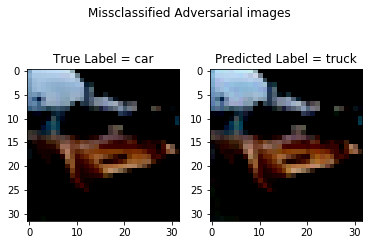

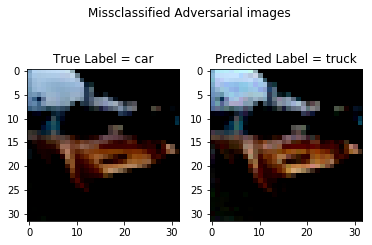

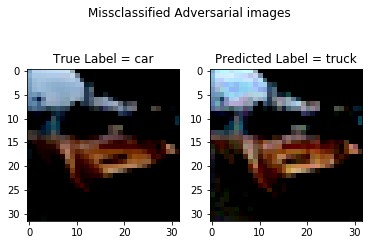

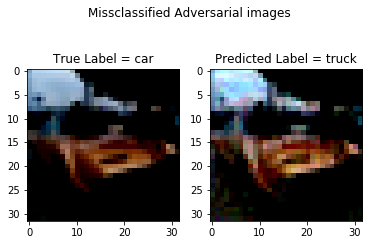

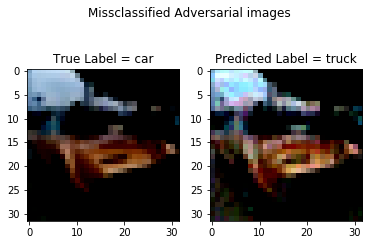

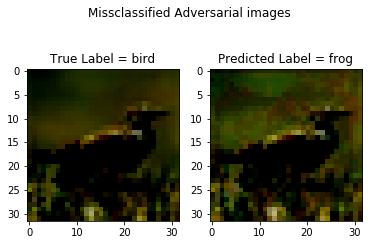

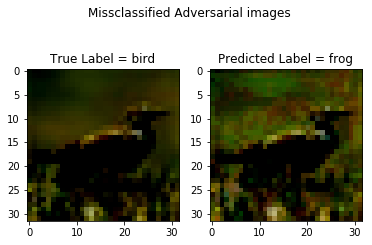

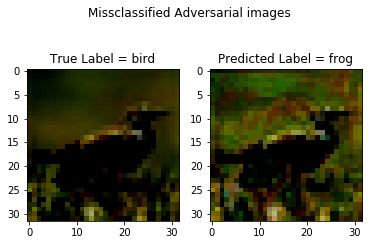

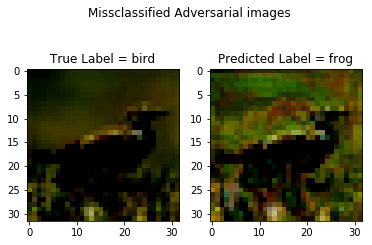

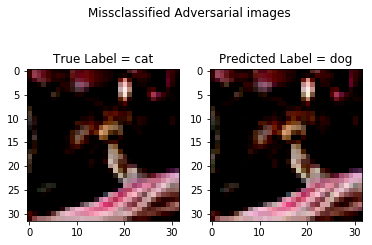

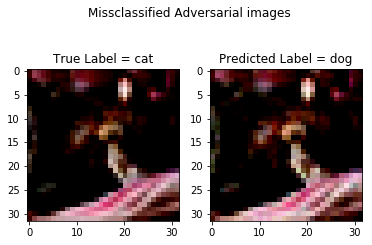

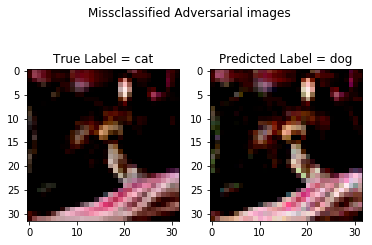

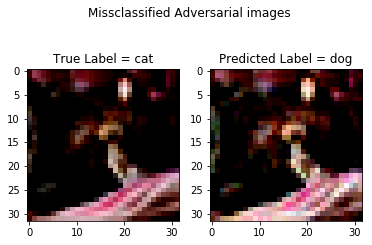

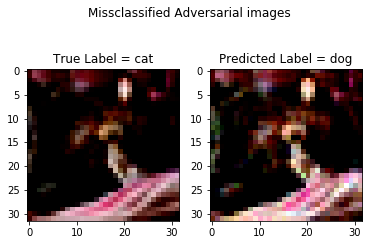

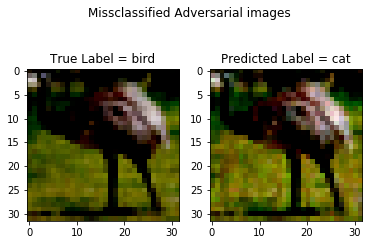

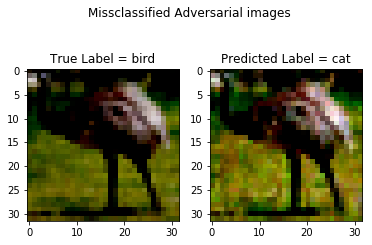

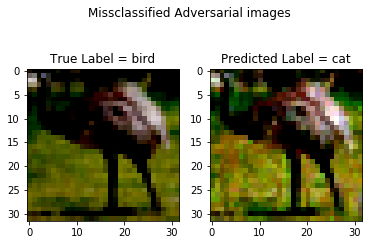

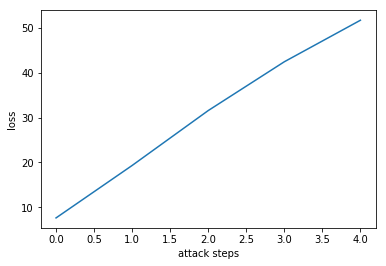

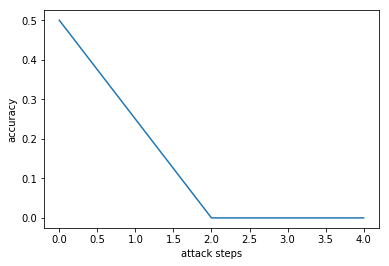

In [10]:
# taking random exaples from test dataset for generating adversarial examples

num_samples = 4
# num_samples = 100

test_indices = [random.randint(0,len(testset)) for x in range(0,num_samples)]

adv_testloader = torch.utils.data.DataLoader(testset , batch_size=1, sampler=SubsetRandomSampler(test_indices))

model = allcnn_t().to(device)
model.load_state_dict(torch.load(data_folder / 'cifar10.pt'))
model.eval()

criterion = nn.CrossEntropyLoss()

# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + torch.clamp(epsilon*sign_data_grad, 0, 1)
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, -1, 1)
    # Return the perturbed image
    return perturbed_image


def test(model, device, testloader, epsilon, attack):
    
    # Accuracy counter
    adv_final_pred_labels = []
    adv_examples = []

    loss_plot = np.zeros([5,num_samples])
    acc_plot = np.ones([5,num_samples])
    i=-1
    # Loop over all examples in test set
    for image,target_label in testloader:
      i+=1  
      probability = 0.0
      
      # Send the data and label to the device
      image, target_label = image.to(device), target_label.to(device)
      
      # print(image)
      # noise = torch.zeros(image.shape, device=device, requires_grad=True)
      perturbed_image = image.clone()

      for attack_step in range(5):     
        # Forward pass the data through the model
        perturbed_image.requires_grad = True
        output = model(perturbed_image)

        init_pred = torch.argmax(torch.exp(output),dim=1)

        # Calculate the loss
        loss = criterion(output,target_label)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()
        
        # Collect datagrad
        data_grad = perturbed_image.grad.data
        # Call FGSM Attack
        perturbed_image = fgsm_attack(perturbed_image.detach().clone(), epsilon, data_grad)
      
        # Re-classify the perturbed image
        with torch.no_grad():
          new_output = model(perturbed_image)
          new_loss = criterion(new_output,target_label)
          _, predicted = torch.max(new_output.data, 1)
#           print(predicted.item(),target_label.item())
          
          loss_plot[attack_step,i] = new_loss.item()
          
          if predicted != target_label:
            acc_plot[attack_step,i] = 0 
          
          if predicted != target_label:
            fig, (ax1, ax2) = plt.subplots(1, 2)
            fig.suptitle('Missclassified Adversarial images')
            ax1.set_title('True Label = {}' .format(classes[target_label.item()]))
            ax2.set_title('Predicted Label = {}' .format(classes[predicted.item()]))
            ax1.imshow(image.cpu().numpy().reshape(3,32,32).transpose([1, 2, 0]))
            ax2.imshow(perturbed_image.detach().cpu().numpy().reshape(3,32,32).transpose([1, 2, 0]))  #change perturbed_image to data_grad for visualizing gradients

    
    loss_plot = np.mean(loss_plot, axis=1)
    acc_plot = np.mean(acc_plot, axis=1)
    
    plt.figure()
    plt.plot(loss_plot)
    plt.xlabel('attack steps')
    plt.ylabel('loss')   
    
    plt.figure()
    plt.plot(acc_plot)
    plt.xlabel('attack steps')
    plt.ylabel('accuracy')   
    plt.show()
    plt.show()
    
    return adv_examples, adv_final_pred_labels

epsilon = 0.05

#random attack
examples, pred_labels = test(model, device, adv_testloader, epsilon, "fgsm")


# fig, (ax1, ax2) = plt.subplots(1, 2)
# fig.suptitle('Adversarial Examples')
# ax1.set_title('Predicted Label = {}' .format(pred_labels[0][0]) + '\n' + 'Probability = {}' .format(pred_labels[0][1]))
# ax2.set_title('Predicted Label = {}' .format(pred_labels[1][0]) + '\n' + 'Probability = {}' .format(pred_labels[1][1]))
# ax1.imshow(examples[0], cmap="gray")
# ax2.imshow(examples[1], cmap="gray")    
